# 1. Get building polygons from OpenStreetMap

## Training area - Limehouse, London
Intially the area I'm using is a section of Limehouse, London. I've chosen this area as the building polygons for terraced houses are accurate and well defined with each house being a single polygon rather than a large connected rectangle. It is also an inner city area with a high density of buildings which will be useful for training and closer to the city typology of the wider Tower Hamlets borough which we will eventually be classifying.

Below is a screenshot of this area on OpenStreetMap.

<p style='text-align: center;'>
    <img src="./data/london/raw-inputs/Limehouse__OSM_Screenshot.png" alt="Limehouse OpenStreetMap Screenshot" width="860"/>
</p>

## Define constants and generate file paths
We'll be using slippy map tiles of `TILE_SIZE = 256` and `ZOOM_LEVEL = 19` which is a good balance between image resolution and processing time for the number of tiles. I'm determine the location to scan from using `LATITUDE_TOP`, `LONGITUDE_LEFT`, `LATITUDE_BOTTOM`, and `LONGITUDE_RIGHT`. These are the boundaries of the area we want to export from [OpenStreetMap](https://www.openstreetmap.org/export#map=17/51.51470/-0.03502) which will be used to extract the building footprints.

First let's import the required libraries and define the constants.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import mercantile
import geopandas as gpd
import rasterio
import solaris as sol
import requests
import shutil
import json

In [9]:
TILE_SIZE = 256
ZOOM_LEVEL = 19
LATITUDE_TOP = 51.51802
LATITUDE_BOTTOM = 51.51239
LONGITUE_LEFT = -0.04105
LONGITUE_RIGHT = -0.03188

# First create a data directory and subdirectories for images and masks
DATA_DIR = Path('./data/london/')
DATA_DIR.mkdir(exist_ok=True)

# Create subdirectory for tile size (s) and zoom level (z)
IMAGE_PATH = DATA_DIR / 'images'
IMAGE_PATH.mkdir(exist_ok=True)

MASKS_PATH = DATA_DIR / 'masks'
MASKS_PATH.mkdir(exist_ok=True)

# Create tile size (s) and zoom level (z) subdirectories within images and masks
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}').mkdir(exist_ok=True)
(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}').mkdir(exist_ok=True)

# Create training and validation subdirectories within images and masks
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'train').mkdir(exist_ok=True)
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'validation').mkdir(exist_ok=True)

(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'train').mkdir(exist_ok=True)
(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'validation').mkdir(exist_ok=True)

## Create a geoJSON bounding box
We will use the `LATITUDE_TOP`, `LONGITUDE_LEFT`, `LATITUDE_BOTTOM`, and `LONGITUDE_RIGHT` to create a GeoJSON bounding box which we can use to extract the building footprints from the OpenStreetMap export.

<AxesSubplot:>

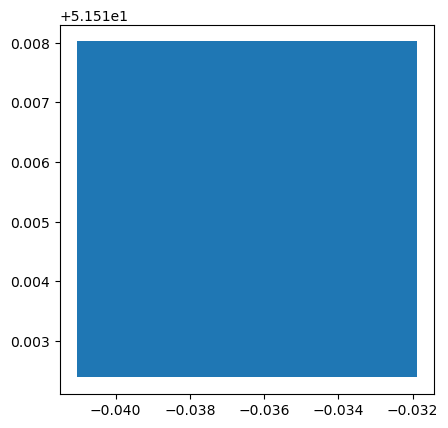

In [11]:
bounding_box_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "coordinates": [
                    [
                        [
                            LONGITUE_LEFT,
                            LATITUDE_TOP
                        ],
                        [
                            LONGITUE_LEFT,
                            LATITUDE_BOTTOM
                        ],
                        [
                            LONGITUE_RIGHT,
                            LATITUDE_BOTTOM
                        ],
                        [
                            LONGITUE_RIGHT,
                            LATITUDE_TOP
                        ],
                        [
                            LONGITUE_LEFT,
                            LATITUDE_TOP
                        ]
                    ]
                ],
                "type": "Polygon"
            }
        }
    ]
}

# Save the bounding box geojson
with open(DATA_DIR / 'raw-inputs' / 'limehouse.geojson', 'w') as f:
    json.dump(bounding_box_geojson, f)

# Create a geodataframe from the bounding box geojson
bounding_box_gdf = gpd.read_file(DATA_DIR / 'raw-inputs' / 'limehouse.geojson')
bounding_box_gdf.plot()

## Generate slippy map tile polygons using supermercado and geopandas

Next we'll use [`supermercado`](https://github.com/mapbox/supermercado) to generate square polygons representing each slippy map satellite image tile. We'll specify a zoom level and make use of the geoJSON bounding box we created earlier.

Use `supermercado burn` to take the input geoJSON bounding box and return a stream of slippy map tile polygons at the specified zoom level. The usage is `<{geojson} stream> | supermercado burn <zoom> | fio collect > {output_filename.geojson}`. 

Run the following printed commands from a bash terminal to generate the building polygons for the training and validation datasets. If like me you are using Windows, you can use the [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/install-win10) to run bash commands.

In [12]:
command = f"cat data/london/raw-inputs/limehouse.geojson | supermercado burn {ZOOM_LEVEL}" + \
                f"| mercantile shapes | fio collect > data/polygons/limehouse_z{ZOOM_LEVEL}tiles.geojson"

print(command)

cat data/london/raw-inputs/limehouse.geojson | supermercado burn 19| mercantile shapes | fio collect > data/polygons/limehouse_z19tiles.geojson


## Request satellite images from Mapbox API
Using Mapbox Raster Tiles API we can download satellite images for our training data using the [Slippy map tilenames](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames). The convention is as follows:
- Tiles are 256 × 256 pixel PNG files
- Each zoom level is a directory, each column is a subdirectory, and each tile in that column is a file
- Filename(url) format is /zoom/x/y.png
- The slippy map expects tiles to be served up at URLs following this scheme, so all tile server URLs look pretty similar.

We'll write some functions that convert latitude and longitude coordinates to tile coordinates which we can pass to our Mapbox GET request.


In [ ]:
# Create bounding box for the area of interest
top_left = (LATITUDE + DELTA, LONGITUE - DELTA)
bottom_right = (LATITUDE - DELTA, LONGITUE + DELTA)

# Create tiles
tl_tiles = mercantile.tile(tl[1],tl[0],z)
br_tiles = mercantile.tile(br[1],br[0],z)
x_tile_range =[tl_tiles.x,br_tiles.x];print(x_tile_range)
y_tile_range = [tl_tiles.y,br_tiles.y];print(y_tile_range)

In [ ]:
# Make a test request to the Mapbox Static Tiles API
res = requests.get('https://api.mapbox.com/v4/mapbox.satellite/'+str(z)+'/'+str(x)+'/'+str(y)+'@2x.pngraw?access_token=pk.eyJ1I....', stream=True)